In [48]:
import pandas as pd
import os

DATA_NUMS = [1, 2, 3, 4, 6, 7, 8, 9, 10, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]

def load_sample_data(num):
    base_path = os.path.join("..", "data", "raw")
    incoming_path = os.path.join(base_path, f"incoming_run_data_{num}.parquet")
    meteo_path = os.path.join(base_path, f"metrology_data{num}.parquet")
    run_path = os.path.join(base_path, f"run_data_{num}.parquet")
    
    incoming_df = pd.read_parquet(incoming_path)
    meteo_df = pd.read_parquet(meteo_path)
    run_df = pd.read_parquet(run_path)
    
    return incoming_df, meteo_df, run_df


In [49]:
# print the head for each dataframe
def print_sample_data_heads():
    for num in DATA_NUMS:
        incoming_df, meteo_df, run_df = load_sample_data(num)
        print(f"Data {num} - Incoming Data Head:")
        print(incoming_df.head())
        print(f"Data {num} - Metrology Data Head:")
        print(meteo_df.head())
        print(f"Data {num} - Run Data Head:")
        print(run_df.head())
        print("\n" + "="*50 + "\n")
        break

# example usage
if __name__ == "__main__":
    print_sample_data_heads()
    # Uncomment the line below to load and print all data heads
    # for num in DATA_NUMS: print_sample_data_heads(num)

Data 1 - Incoming Data Head:
                                Tool ID Run Start Time        Run End Time  \
0  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2023-12-31 2023-12-31 00:12:22   
1  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2023-12-31 2023-12-31 00:12:22   
2  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2023-12-31 2023-12-31 00:12:22   
3  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2023-12-31 2023-12-31 00:12:22   
4  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2023-12-31 2023-12-31 00:12:22   

                                 Run ID                          Process Step  \
0  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
1  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
2  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
3  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
4  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   

  Step ID      

#### The following snippet asserts that the (X_index, Y_index) tuple is the same across all dataframes in metrology data. 

In [28]:
_, meteo_df, _ = load_sample_data(1)

run_ids = meteo_df["Run ID"].unique()
ref_run_id = run_ids[0]
ref_coords = set(
    tuple(row) for row in meteo_df[meteo_df["Run ID"] == ref_run_id][["X_index", "Y_index", "Point Index"]].to_numpy()
)


for num in DATA_NUMS:
    _, meteo_df, _ = load_sample_data(num)

    run_ids = meteo_df["Run ID"].unique()
    for run_id in run_ids:
        coords = set(
            tuple(row) for row in meteo_df[meteo_df["Run ID"] == run_id][["X_index", "Y_index", "Point Index"]].to_numpy()
        )
        assert coords == ref_coords, f"Coordinates do not match for run ID {run_id} in data {num}"
    


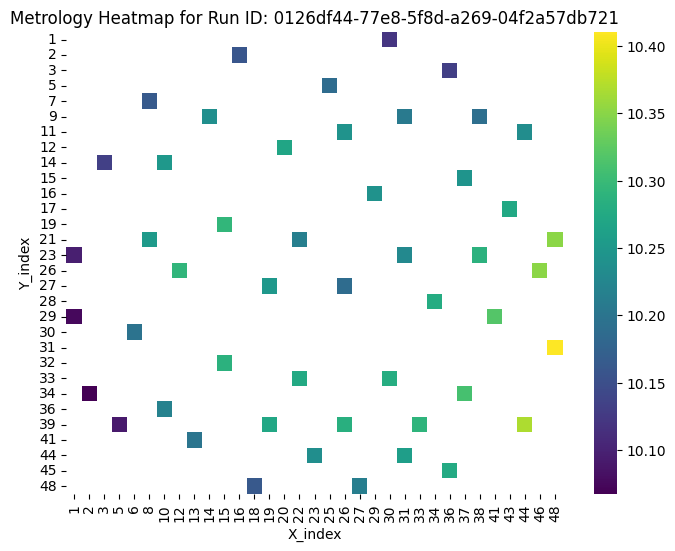

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for num in DATA_NUMS:
    sample_run_id = meteo_df['Run ID'].iloc[0]
    sample = meteo_df[meteo_df['Run ID'] == sample_run_id]

    plt.figure(figsize=(8, 6))
    pivot = sample.pivot_table(index='Y_index', columns='X_index', values='Measurement')
    sns.heatmap(pivot, cmap='viridis')
    plt.title(f"Metrology Heatmap for Run ID: {sample_run_id}")
    plt.show()
    break

#### Check that Tool ID is unique and has no overlap across all datasets

In [29]:
# check that there is only 1 unique tool id per dataset in incoming and run data
for num in DATA_NUMS:
    incoming_df, _, run_df = load_sample_data(num)

    incoming_tool_ids = incoming_df["Tool ID"].unique()
    run_tool_ids = run_df["Tool ID"].unique()

    assert len(incoming_tool_ids) == 1, f"Multiple tool IDs found in incoming data for dataset {num}"
    assert len(run_tool_ids) == 1, f"Multiple tool IDs found in run data for dataset {num}"

In [30]:
# check that there is no overlap in tool ids across datasets incoming and run

for num in DATA_NUMS:
    incoming_df, _, run_df = load_sample_data(num)

    incoming_tool_ids = set(incoming_df["Tool ID"].unique())
    run_tool_ids = set(run_df["Tool ID"].unique())

    for other_num in DATA_NUMS:
        if other_num == num:
            continue
        other_incoming_df, _, other_run_df = load_sample_data(other_num)
        other_incoming_tool_ids = set(other_incoming_df["Tool ID"].unique())
        other_run_tool_ids = set(other_run_df["Tool ID"].unique())

        assert not (incoming_tool_ids & other_incoming_tool_ids), f"Overlap found in incoming tool IDs between datasets {num} and {other_num}"
        assert not (run_tool_ids & other_run_tool_ids), f"Overlap found in run tool IDs between datasets {num} and {other_num}"

#### Run and Incoming Run ID's are consistent and can be joined

In [46]:
# check count of unique run ids per run and incoming dataset and print it
for num in DATA_NUMS:
    incoming_df, _, run_df = load_sample_data(num)

    incoming_run_ids_count = incoming_df["Run ID"].nunique()
    run_run_ids_count = run_df["Run ID"].nunique()

    incoming_run_ids = set(incoming_df["Run ID"].unique())
    run_run_ids = set(run_df["Run ID"].unique())

    assert incoming_run_ids_count == run_run_ids_count, f"Mismatch in number of unique run IDs for dataset {num}"
    assert incoming_run_ids == run_run_ids, f"Run IDs do not match between incoming and run data for dataset {num}"

#### Process step is useless

In [ ]:
# check if process step is different across datasets
list_of_process_steps_incoming = set()
list_of_process_steps_run = set()
for num in DATA_NUMS:
    incoming_df, _, run_df = load_sample_data(num)

    incoming_process_steps = incoming_df["Process Step"].unique()
    run_process_steps = run_df["Process Step"].unique()

    list_of_process_steps_incoming.add(tuple(incoming_process_steps))
    list_of_process_steps_run.add(tuple(run_process_steps))


print("Unique process steps in INCOMING across datasets:")
print(list_of_process_steps_incoming)
print("Unique process steps in RUN across datasets:")
print(list_of_process_steps_run)


Unique process steps in INCOMING across datasets:
{('22c8716b-1c14-525a-8c0a-0473ec7aa99e',)}
Unique process steps in RUN across datasets:
{('22c8716b-1c14-525a-8c0a-0473ec7aa99e',)}


#### STEP ID: Incoming is steps 0 to 7, run is steps 0 to 12

In [47]:
# print the unique step ids in each dataset
for num in DATA_NUMS:
    incoming_df, _, run_df = load_sample_data(num)

    incoming_step_ids = incoming_df["Step ID"].unique()
    run_step_ids = run_df["Step ID"].unique()

    print(f"Dataset {num}:")
    print(f"  Incoming Step IDs: {incoming_step_ids}")
    print(f"  Run Step IDs: {run_step_ids}")

Dataset 1:
  Incoming Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7']
  Run Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7'
 'Step_8' 'Step_9' 'Step_10' 'Step_11' 'Step_12']
Dataset 2:
  Incoming Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7']
  Run Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7'
 'Step_8' 'Step_9' 'Step_10' 'Step_11' 'Step_12']
Dataset 3:
  Incoming Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7']
  Run Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7'
 'Step_8' 'Step_9' 'Step_10' 'Step_11' 'Step_12']
Dataset 4:
  Incoming Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7']
  Run Step IDs: ['Step_0' 'Step_1' 'Step_2' 'Step_3' 'Step_4' 'Step_5' 'Step_6' 'Step_7'
 'Step_8' 'Step_9' 'Step_10' 'Step_11' 'Step_12']
Dataset 6:
  Incomin

#### All sensor data present across all datasets

In [ ]:
# print the sensor names and the count of each sensor name 

#### This cell shows the rows of a particular ['Run ID', 'Step ID'] group, so the idea is to aggregate it additionally with the Sensor ID (since there are 3 taken at a second apart) and extract features like mean, max, median, std etc.

In [ ]:
# list everything from run_df for the first ['Run ID', 'Step ID']
def list_run_steps(run_df, run_id, step_id):
    steps = run_df[(run_df['Run ID'] == run_id) & (run_df['Step ID'] == step_id)]
    return steps

# Example usage
for num in DATA_NUMS:
    _, _, run_df = load_sample_data(num)
    sample_run_id = run_df['Run ID'].iloc[0]
    sample_step_id = run_df['Step ID'].iloc[0]
    
    steps = list_run_steps(run_df, sample_run_id, sample_step_id)
    print(f"Run ID: {sample_run_id}, Step ID: {sample_step_id}")
    print(steps.head())
    break  # Just to show for the first dataset

# # send output to a file
# output_file = "run_steps_output.txt"
# with open(output_file, 'w') as f:
#     for num in DATA_NUMS:
#         _, _, run_df = load_sample_data(num)
#         sample_run_id = run_df['Run ID'].iloc[0]
#         sample_step_id = run_df['Step ID'].iloc[0]
        
#         steps = list_run_steps(run_df, sample_run_id, sample_step_id)
#         f.write(f"Run ID: {sample_run_id}, Step ID: {sample_step_id}\n")
#         f.write(steps.to_string(index=False) + "\n\n")

Run ID: 6515456b-05d4-5e6d-b42a-7652a8d671a4, Step ID: Step_0
                                  Tool ID Run Start Time        Run End Time  \
0    8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
1    8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
2    8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
722  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
723  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   

                                   Run ID  \
0    6515456b-05d4-5e6d-b42a-7652a8d671a4   
1    6515456b-05d4-5e6d-b42a-7652a8d671a4   
2    6515456b-05d4-5e6d-b42a-7652a8d671a4   
722  6515456b-05d4-5e6d-b42a-7652a8d671a4   
723  6515456b-05d4-5e6d-b42a-7652a8d671a4   

                             Process Step  Consumable Life Step ID  \
0    22c8716b-1c14-525a-8c0a-0473ec7aa99e         370.7229  Step_0   
1    22c8716b-1c14-525a-8c0a-0473ec7aa99e     

## Joins and Grouping EDA

In [ ]:
for num in DATA_NUMS:
    incoming_df, meteo_df, run_df = load_sample_data(num=num)
    # print all the unique run ids
    print("Unique Run IDs:")
    print(f"Incoming: {incoming_df['Run ID'].nunique()}")
    print(f"Run: {run_df['Run ID'].nunique()}")
    print(f"Metrology: {meteo_df['Run ID'].nunique()}")
    # print the len of common run ids
    # print the common run ids
    print("Len of common Run IDs:")
    print(f"Incoming: {len(set(incoming_df['Run ID']).intersection(run_df['Run ID']))}")
    print(f"Run: {len(set(run_df['Run ID']).intersection(meteo_df['Run ID']))}")
    print(f"Metrology: {len(set(meteo_df['Run ID']).intersection(incoming_df['Run ID']))}")

    print(" ----------------------- ")

Unique Run IDs:
Incoming: 225
Run: 225
Metrology: 225
Len of common Run IDs:
Incoming: 225
Run: 225
Metrology: 225
 ----------------------- 
Unique Run IDs:
Incoming: 225
Run: 225
Metrology: 225
Len of common Run IDs:
Incoming: 225
Run: 225
Metrology: 225
 ----------------------- 
Unique Run IDs:
Incoming: 225
Run: 225
Metrology: 225
Len of common Run IDs:
Incoming: 225
Run: 225
Metrology: 225
 ----------------------- 
Unique Run IDs:
Incoming: 225
Run: 225
Metrology: 225
Len of common Run IDs:
Incoming: 225
Run: 225
Metrology: 225
 ----------------------- 
Unique Run IDs:
Incoming: 225
Run: 225
Metrology: 225
Len of common Run IDs:
Incoming: 225
Run: 225
Metrology: 225
 ----------------------- 
Unique Run IDs:
Incoming: 225
Run: 225
Metrology: 225
Len of common Run IDs:
Incoming: 225
Run: 225
Metrology: 225
 ----------------------- 
Unique Run IDs:
Incoming: 225
Run: 225
Metrology: 225
Len of common Run IDs:
Incoming: 225
Run: 225
Metrology: 225
 ----------------------- 
Unique Run ID